# Part I : Analyse descriptive
## Contexte de l’analyse

###  Le jeu de données. 
Dans ce notebook nous avons utlisé Python 3.8 avec les biblithèques en lignes mensionées dans la cellule suivantes. L'ordre des questions est respécté pour le traitement du sujet.

In [2]:
# Import des libraries classique (numpy, pandas, ...)
import pandas as pd
import numpy as np


## sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV


# XGBoost
from xgboost import XGBClassifier
from xgboost import plot_importance

## visualisation des données
import seaborn as sns
import matplotlib.pyplot as plt

## visulalisation des valeurs manquantes
import missingno

## Test statistiques
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
import statsmodels


import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import du dataframe "data.csv"
data_path= "./data.csv"
df =pd.read_csv(data_path, index_col=[0]).set_index("index") 
df.date = pd.to_datetime(df.date)# convertir la variable date au type datetime
df1=df.copy()
df1.date = pd.to_datetime(df1.date)

In [4]:
df.head()

,date,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
index,,,,,,,,,,,
0,2012-06-02,roux,25.0,9.0,26803.0,F,licence,geologie,97.08,non,0
1,2011-04-21,blond,35.0,13.0,38166.0,M,licence,forage,63.86,non,0
2,2012-09-07,blond,29.0,13.0,35207.0,M,licence,geologie,78.50,non,0
3,2011-07-01,brun,NaN,12.0,32442.0,M,licence,geologie,45.09,non,0
4,2012-08-07,roux,35.0,6.0,28533.0,F,licence,detective,81.91,non,0


In [4]:
df.dtypes

date          datetime64[ns]
cheveux               object
age                  float64
exp                  float64
salaire              float64
sexe                  object
diplome               object
specialite            object
note                 float64
dispo                 object
embauche               int64
dtype: object

In [3]:
y=df.embauche
y.unique()

array([0, 1], dtype=int64)

## EDA

In [6]:
a=df[df.embauche==1] ##  pour analyser les profils embauchés
b=df[df.embauche==0] ##  pour analyser les profils non embauchés

<AxesSubplot:ylabel='embauche'>

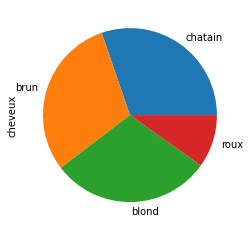

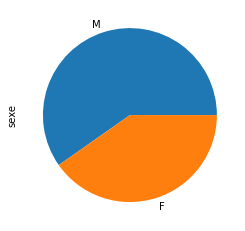

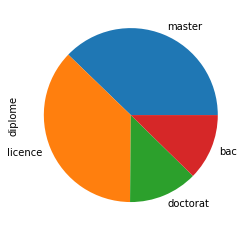

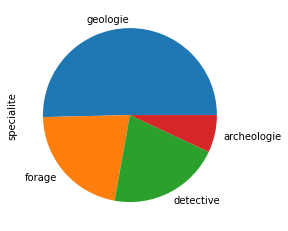

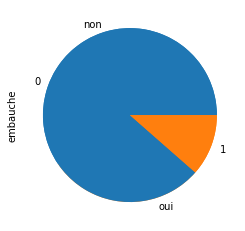

In [7]:
for col in df.select_dtypes('object'):
    plt.figure()
    df[col].value_counts().plot.pie()
df['embauche'].value_counts().plot.pie()

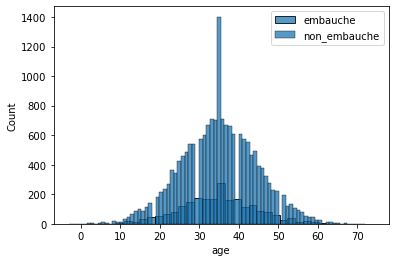

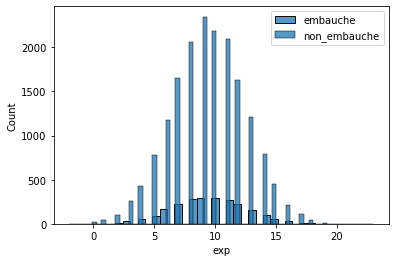

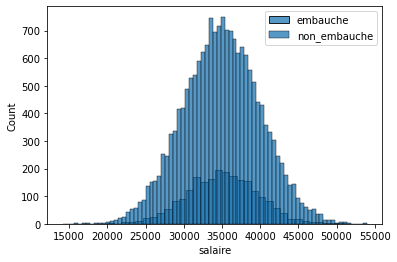

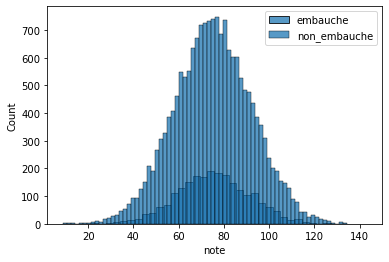

In [24]:
for col in df.select_dtypes('float'):
    plt.figure()
    sns.histplot(a[col],  label='embauche')
    sns.histplot(b[col],  label='non_embauche')
    plt.legend()

<Figure size 432x288 with 0 Axes>

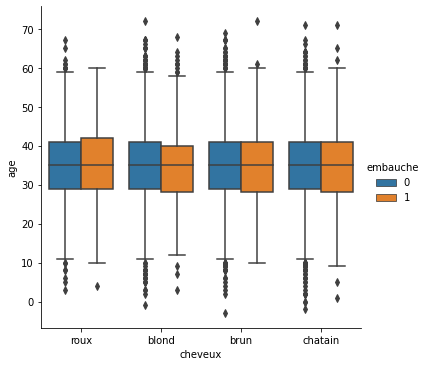

<Figure size 432x288 with 0 Axes>

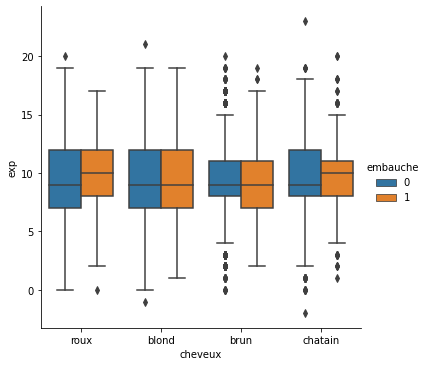

<Figure size 432x288 with 0 Axes>

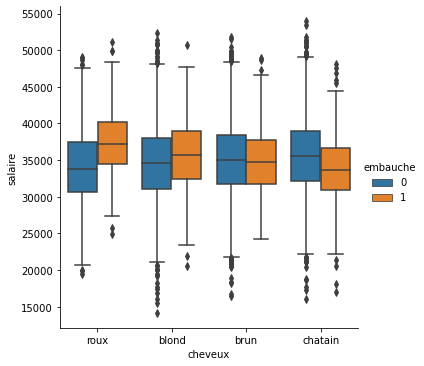

<Figure size 432x288 with 0 Axes>

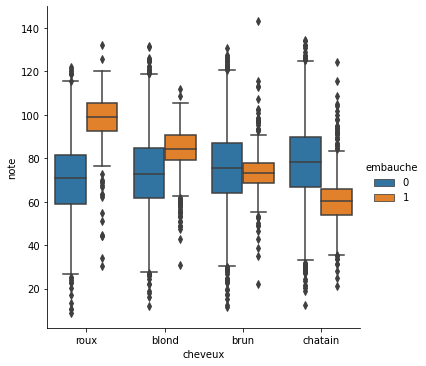

<Figure size 432x288 with 0 Axes>

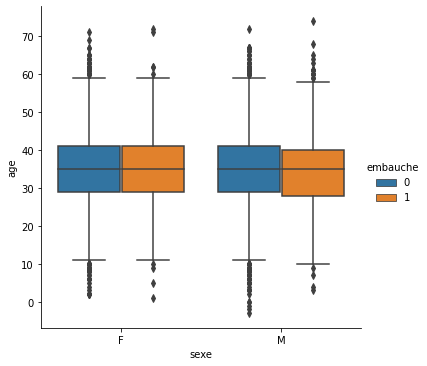

<Figure size 432x288 with 0 Axes>

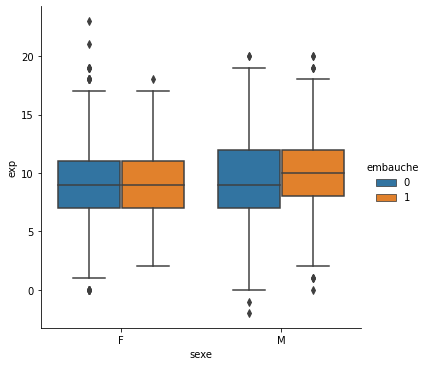

<Figure size 432x288 with 0 Axes>

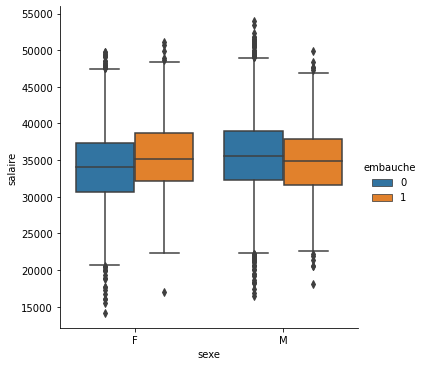

<Figure size 432x288 with 0 Axes>

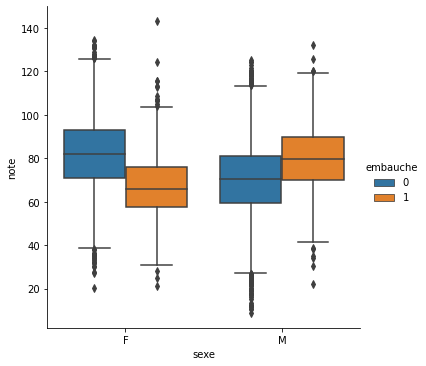

<Figure size 432x288 with 0 Axes>

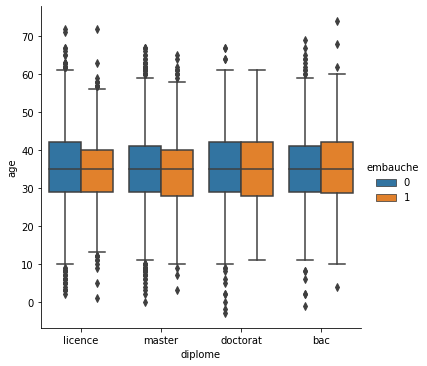

<Figure size 432x288 with 0 Axes>

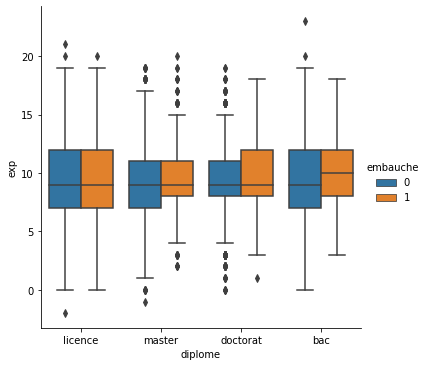

<Figure size 432x288 with 0 Axes>

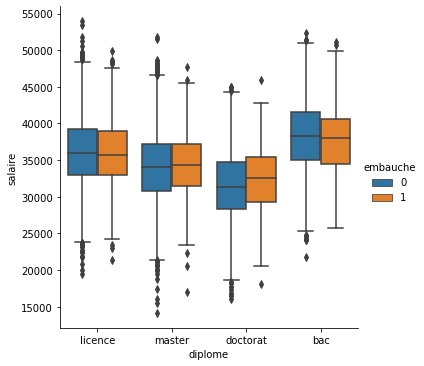

<Figure size 432x288 with 0 Axes>

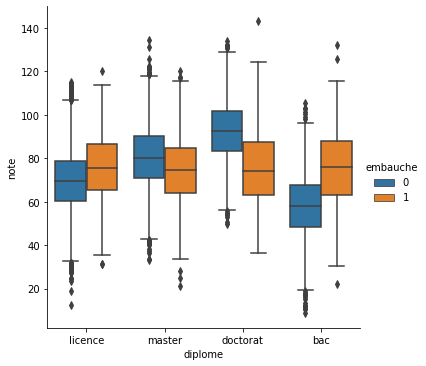

<Figure size 432x288 with 0 Axes>

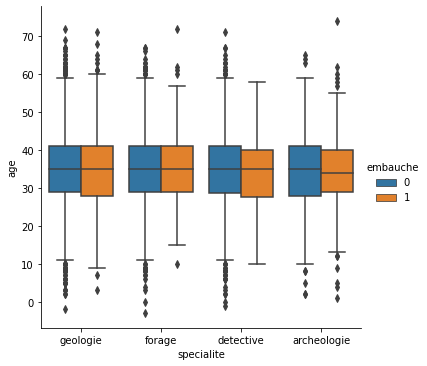

<Figure size 432x288 with 0 Axes>

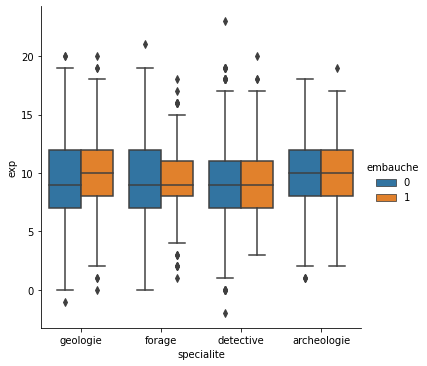

<Figure size 432x288 with 0 Axes>

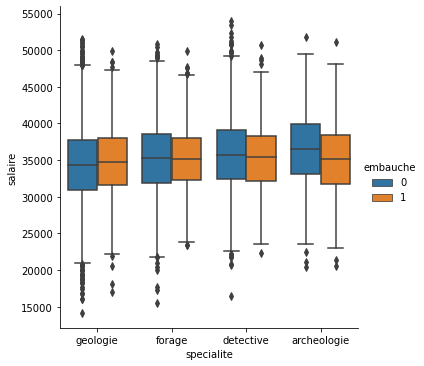

<Figure size 432x288 with 0 Axes>

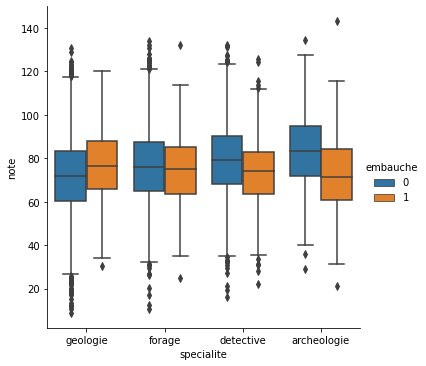

<Figure size 432x288 with 0 Axes>

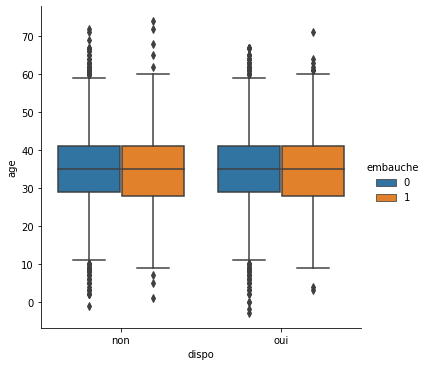

<Figure size 432x288 with 0 Axes>

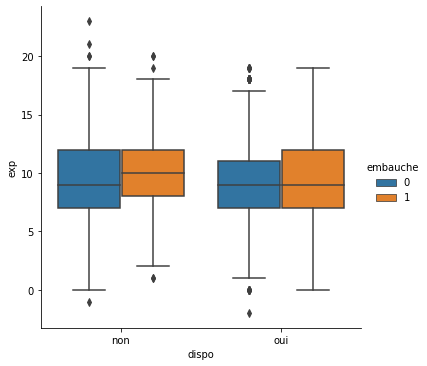

<Figure size 432x288 with 0 Axes>

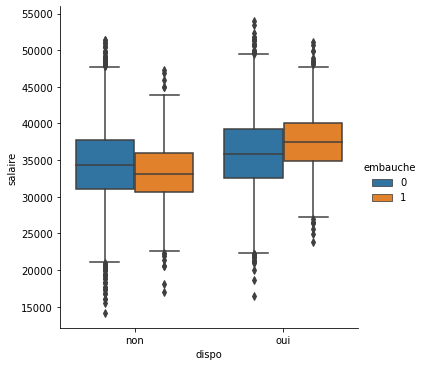

<Figure size 432x288 with 0 Axes>

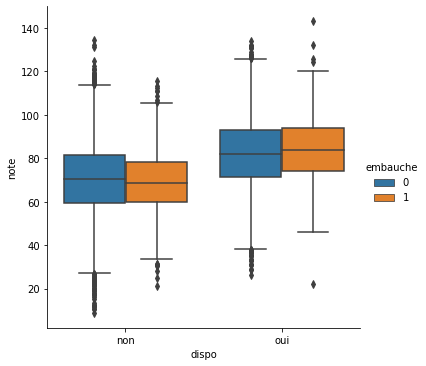

In [28]:
# disribution des variables categorielles par rapport au variables continues pour tout les candidats
for col in df.select_dtypes('object'):
    for coll in df.select_dtypes('float'):
        plt.figure()
        sns.catplot(x=col, y=coll, hue="embauche", kind="box", data=df)

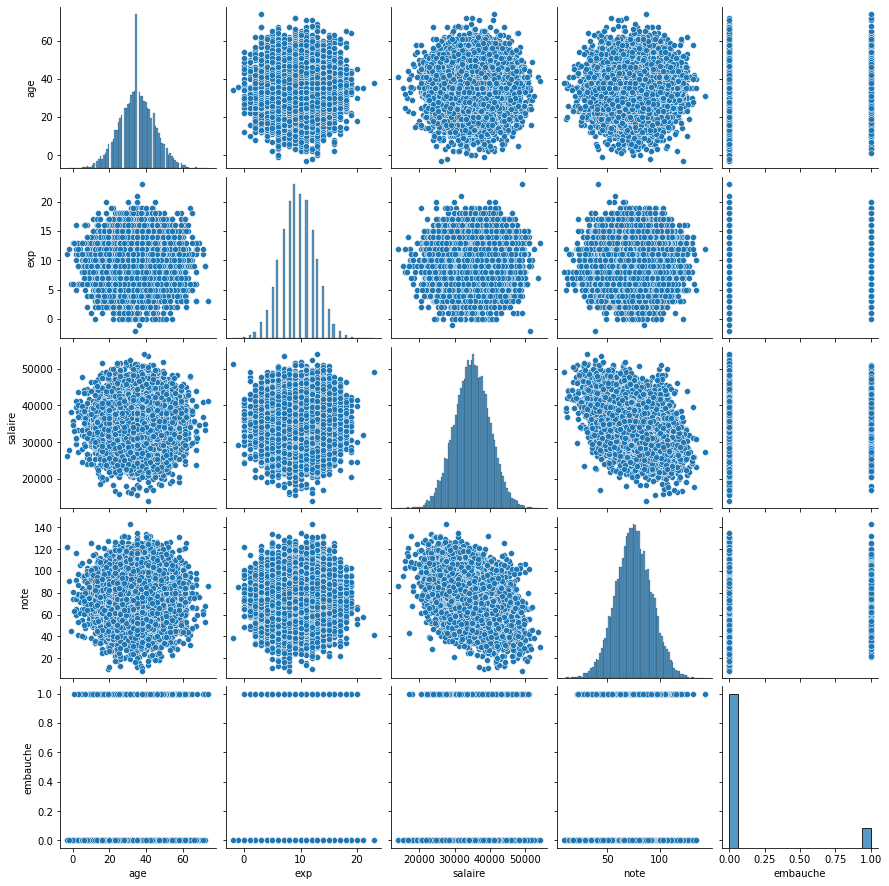

In [29]:
df1=df
df.embauche = df.embauche.astype(object)
sns.pairplot(df1[df1.columns])

* Le salaire et la note ont une corrélation entre eux, pour le reste aucune corrélation claire n'est visible sur les graphes.

In [7]:
df.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
date,19909,1826,2012-02-03 00:00:00,24,2010-01-01,2014-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cheveux,19897,4,chatain,6022,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,19909,NaN,NaN,NaN,NaT,NaT,35.0045,9.60917,-3,29,35,41,74
exp,19904,NaN,NaN,NaN,NaT,NaT,9.50035,3.01211,-2,7,9,12,23
salaire,19905,NaN,NaN,NaN,NaT,NaT,34974.3,5003.1,14128,31596,34979,38358,53977
sexe,19900,2,M,11889,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
diplome,19890,4,master,7513,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
specialite,19907,4,geologie,10028,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
note,19886,NaN,NaN,NaN,NaT,NaT,75.1688,17.0959,8.68,63.72,75.08,86.6175,143.22
dispo,19894,2,non,11848,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* Ce que nous pouvons dire :
    - Il y a des valeurs manquantes dans tout les variables
    - Nous avons des variables catégoriels que nous allons gérer par la suite
    - L'existance de certains valeurs bizzares : des valeur négatives pour les variables age et expérience !
    - L'existance  de valeurs extrèmes (comparer 75% et le max) 

#### Traitement des valeurs manquantes

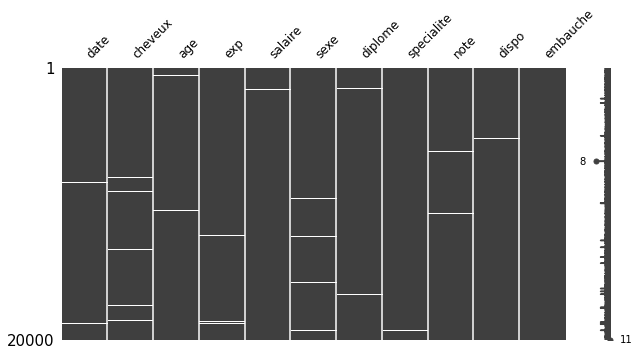

In [8]:
## visualisation des valeurs manquantes
missingno.matrix(df,figsize=(10,5), fontsize=12);

* Nous allons d'abord voir si nous pouvons faire une régression entre la variable expérience et la variable âge. Cela nous permettra de mieux prédire leurs valeurs manquantes puisqu'il n'y a pas de chevauchement dans les indices de leurs variables manquantes.

In [11]:
## test de pearson
pd.DataFrame(pearsonr(df1.exp, df1.age),
                     index = ['pearson_coeff','p_value'],
                     columns = ['résultat_test'])

,résultat_test
pearson_coeff,-0.001838
p_value,0.799946


* L’hypothèse nulle à tester est : « les deux variables testées sont indépendantes ». Selon le test de corrélation de Pearson appliqué et puisque la valeur p est très supérieur à 0.05, nous nous pouvons pas rejeté l'hypothèse nulle.

* Afin de traiter les valeur manquantes : 
 -  Pour les variables continues, nous allons remplacé leurs valeurs manquantes par la médiane (pour éviter l'impact des valeurs extrèmes) 

 -  pour les variables catégorielles nous allons supprimer les lignes qui contient des valeurs manquantes puisque nous ne pouvons pas voter sur une valeur précise et pour éviter de biaser notre base de donnée. Cette étape est importante car nous ne pouvons pas appliquer notre modèle avec des variables manquantes. 

In [49]:
## changement de valeurs dans le dataphrame df
df.loc[df.age.isnull(), 'age'] = df.age.median()
df.loc[df.exp.isnull(), 'exp'] = df.exp.median()
df.loc[df.salaire.isnull(), 'salaire'] = df.salaire.median()
df.loc[df.note.isnull(), 'note'] = df.note.median()
## suppression des lignes avec des valeurs manquantes
df = df.dropna(axis=0)

Nous allons commencer par la varibale date

In [13]:
df1['mois'] = df1.date.dt.month
df1['year'] = df1.date.dt.year

Text(0.5, 1.0, 'nombre des embauchés chaque année par mois')

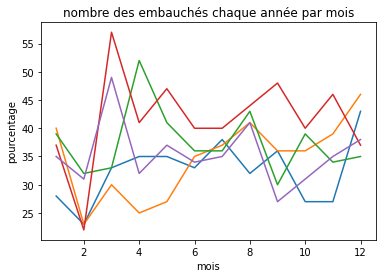

In [14]:
# nombre des embauchés chaque année par mois
a=df1[df1.year==2010]
b=df1[df1.year==2011]
c=df1[df1.year==2012]
d=df1[df1.year==2013]
e=df1[df1.year==2014]
plt.plot(a.groupby('mois')['embauche'].sum())
plt.plot(b.groupby('mois')['embauche'].sum())
plt.plot(c.groupby('mois')['embauche'].sum())
plt.plot(d.groupby('mois')['embauche'].sum())
plt.plot(e.groupby('mois')['embauche'].sum())
plt.xlabel('mois')
plt.ylabel('pourcentage')
plt.title('nombre des embauchés chaque année par mois')

Text(0.5, 1.0, 'nombre des embauche par mois')

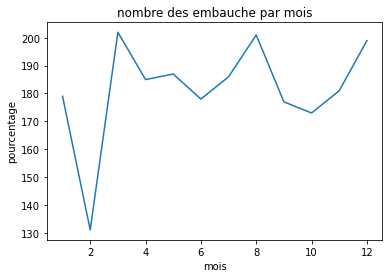

In [15]:
# le nombre des embauchés par mois
plt.plot(df1.groupby('mois')['embauche'].sum())
plt.xlabel('mois')
plt.ylabel('pourcentage')
plt.title('nombre des embauche par mois')

Text(0.5, 1.0, 'pourcentage des embauche chaque année par mois')

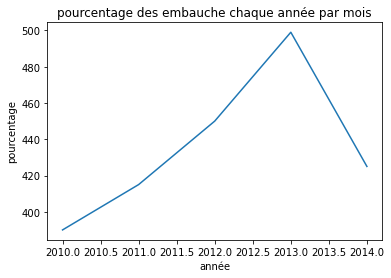

In [16]:
# nombre des embauches par année
plt.plot(df1.groupby('year')['embauche'].sum())
plt.xlabel('année')
plt.ylabel('pourcentage')
plt.title('pourcentage des embauche chaque année par mois')

* Les variables mois et année de candidature ont une influence sur le succès de la candidature donc la variable date a un impact.  
* Pour les mois, nous avons un comportement commun d'une diminution du taux d'admission de janvier à février (tous les graphiques commencent avec une pente négative) et une augmentation de février à mars. Pour le reste des mois, nous ne pouvons pas dire grand chose.
* Pour les années, il est clair qu'il y a des années avec un taux d'admission plus élevé.

Afin de prendre en compte la variable date, nous allons la remplacer par la variable mois qui nous donne le numéro du mois de la candidature. Nous n'allons pas utiliser la variable année car nous considérons que l'année de la demande ne doit pas influencer notre modèle qui doit être capable de prédire les profils des éventuelles candidatures futures.

In [17]:
# ajout des variable mois et annee
df['mois'] = df.date.dt.month

In [31]:
# le pourcentage des embauchés parmi les dispos et les non-dispos
df.groupby('dispo')['embauche'].mean()

dispo
non    0.111947
oui    0.117849
Name: embauche, dtype: float64

In [32]:
# le pourcentage des embauchés par specialité
df.groupby('specialite')['embauche'].mean()

specialite
archeologie    0.205601
detective      0.100445
forage         0.091704
geologie       0.117202
Name: embauche, dtype: float64

* La spécialité archéologie est au moins deux fois plus souhaitable que les autres spécialités.
* Nous avons le même pourcentage d'admission pour la variable de disponibilité.

In [33]:
# le pourcentage des embauchés par specialité
df.groupby('diplome')['embauche'].mean()

diplome
bac         0.083928
doctorat    0.087846
licence     0.121460
master      0.126228
Name: embauche, dtype: float64

* Les diplômes de master et de doctorat sont les plus recherchés

In [35]:
# le pourcentage des embauchés par couleur de cheveux
df.groupby('cheveux')['embauche'].mean()

cheveux
blond      0.117178
brun       0.115825
chatain    0.109713
roux       0.115405
Name: embauche, dtype: float64

* Nous avons le même pourcentage d'admission pour chaque couleur de cheveux. De plus, pour l'admission d'un candidat, la couleur des cheveux n'est généralement pas prise en compte, surtout pour les postes en thèse. Nous ferons donc l'hypothèse que cette variable n'est pas nécessaire pour la prédiction.

## une dépendance statistiquement significative entre :

#### (a) La spécialité et le sexe 

In [37]:
# Table de contingence : tableau de croisement entre les modalités des deux variables
table = pd.crosstab(df.specialite, df.sexe)
table

sexe,F,M
specialite,,
archeologie,1066,291
detective,2457,1585
forage,1931,2300
geologie,2364,7414


* l’hypothèse nulle est « les deux variables testées sont indépendantes ». Nous allons étudier cette hypothèse à l'aide du test de chi 2

In [38]:
resultat_test = chi2_contingency(table)
print('Statistique de test: ',resultat_test[0])
print('p-value: ',            resultat_test[1])
print('Degré de libeté: ',    resultat_test[2])

Statistique de test:  2637.596911217624
p-value:  0.0
Degré de libeté:  3


* l'hypothèse nulle  est rejetée (p<5%) et il y a donc une dépendance statistique entre spécialité et sexe

Mesurons le niveau de dépendance entre les deux variables en utilisant le V de Cramer. Il se calcule à l’aide de la statistique de test, du degré de liberté et des dimensions de la table de contingence. Il renvoie une valeur entre 0 et 1

In [39]:
# table de contingence avec margins
table = pd.crosstab(df.specialite, df.sexe, margins=True)
table

sexe,F,M,All
specialite,,,
archeologie,1066,291,1357
detective,2457,1585,4042
forage,1931,2300,4231
geologie,2364,7414,9778
All,7818,11590,19408


In [40]:
from math import sqrt
# Récupération de la taille d’échantillon 
n = 19809 # voir table de contingence avec margins
# Récupération du nombre de modalité de chaque variable
p = 2
q = 4
# Calcul du dénominateur du V de Cramér
m = min(p-1,q-1)
# Calcul du V de Cramér
V = sqrt(resultat_test[0]/(n * m))
print('la valeur de V de Cramer est : ', V)

la valeur de V de Cramer est :  0.36489922147130044


* Comme V=0.37, la dépendance entre spécialité et sexe est plutôt une dépendance significative et modérée

#### (b) La couleur de cheveux et le salaire demandé 

Corrélation entre une variable continue et une variable catégorielle :

Pour étudier ce type de corrélation on peut faire un recours à l’analyse de la variance (ANOVA) à un facteur qui permet de comparer les moyennes d’échantillon.

In [55]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['salaire']] = scaler.fit_transform(df[['salaire']])

<AxesSubplot:xlabel='cheveux', ylabel='salaire'>

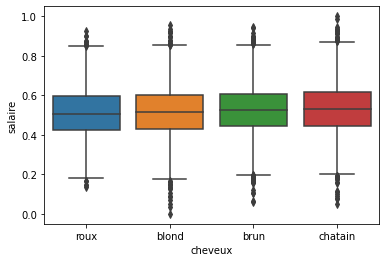

In [56]:
sns.boxplot(x='cheveux', y='salaire', data=df)

* Il n'y a pas de dépendance entre cheveux et Salaire (les distributions des salaires sont quasi-identiques d'un type de cheveux à l'autre)

In [50]:
### 1 ère méthode

from scipy.stats import stats

roux=df.loc[df.cheveux=='roux']['salaire']
blond=df.loc[df.cheveux=='blond']['salaire']
brun=df.loc[df.cheveux=='brun']['salaire']
chatain=df.loc[df.cheveux=='chatain']['salaire']

stats.f_oneway(roux,blond,brun,chatain)

F_onewayResult(statistic=28.795785005322664, pvalue=1.4355479066310955e-18)

<AxesSubplot:xlabel='cheveux', ylabel='salaire'>

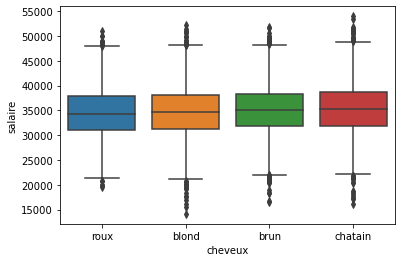

In [32]:
sns.boxplot(x='cheveux', y='salaire', data=df)

In [57]:
## 2 ème méthode
## même résultats

import statsmodels.api
result = statsmodels.formula.api.ols(' salaire ~ cheveux', data=df).fit()
table = statsmodels.api.stats.anova_lm(result)
table

,df,sum_sq,mean_sq,F,PR(>F)
cheveux,3.0,1.348262,0.449421,28.795785,1.435548e-18
Residual,19404.0,302.841590,0.015607,NaN,NaN


#### (c) Le nombre d’années d’expérience et la note à l’exercice 

Corrélation entre deux variables continues : le test de corrélation de Pearson avec la même hypothèse nulle.

In [58]:
pd.DataFrame(pearsonr(df.exp, df.note),
                     index = ['pearson_coeff','p_value'],
                     columns = ['résultat_test'])

,résultat_test
pearson_coeff,-0.010933
p_value,0.127749


* l'hypothèse nulle  est n'est pas rejetée (p>5%). 
* le coefficient a une valeur de -0.01  (valeur très faible et proche de zéro) ce qui signifie que les variables sont très faiblement corrélées.

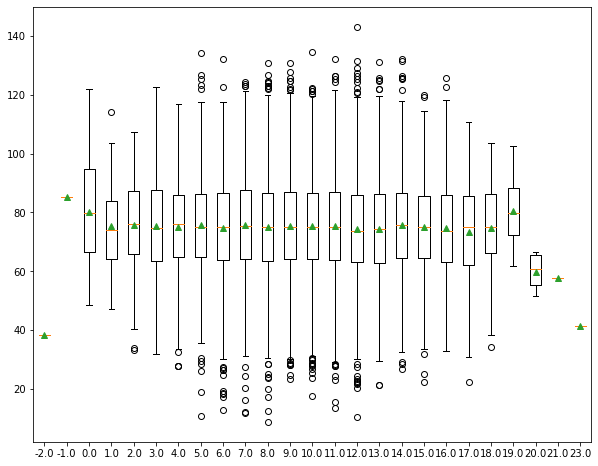

In [43]:
Lexp = sorted(df.exp.unique())
Lnote = []

for el in Lexp:
    notes = df[df.exp==el]['note'].dropna()
    Lnote.append(notes.values)
    
fig, ax = plt.subplots(figsize=(10,8))    
ax.boxplot(Lnote, labels=Lexp, showmeans=True)
plt.show()

* Le graphique illustre ce que nous avons constaté mathématiquement. Une dépendance faible sauf pour les profils très expérimentés (ceci s'explique par le fait qu'ils ne se souviennent pas des concepts théoriques).

# Part II : Machine Learning

###  Un modèle permettant de prédire la variable embauche, avec optimisation des paramètres

* Le Gradient Boosting est un algorithme d'apprentissage supervisé dont le principe est de combiner les résultats d'un ensemble de modèles plus simples et plus faibles pour fournir une meilleure prédiction. 
* La prédiction de la variable embauche est un problème de classification binaire qui nécessite un algorithme d'apprentissage supervisé, nous allons donc utiliser un classificateur pour prédire cette variable.
* Nous utiliserons le classificateur XGBoost qui est une véritable star des compétitions de Machine Learning et qui est basé sur des arbres de décision. En effet, la plupart des variables que nous avons sont soit des variables catégorielles soit des variables entières (même si leur type est float) donc il y aura toujours des profils similaires (nous pouvons toujours trouver des profils avec 2 ans d'expérience et avec d'autres caractéristiques en commun, au contraire si l'expérience est une variable réelle il est difficile de trouver deux candidats avec la même valeur d'expérience). Les modèles basés sur les arbres de décision sont performants pour reconnaître les profils similaires. Le modèle Catboost fait également partie des nouveaux modèles puissants basés sur les arbres de décision, mais nous avons choisi XGBoost.

#### Pré-traitement des données

Nous avons appliqué les deux méthodes les plus connues pour transformer nos variables catégorielles en variables numériques. Il s'avère que le Labelencoding donne de meilleures performances que le OnehotEncoding bien que ce dernier soit plus favorisé puisqu'il n'entraîne pas le modèle à reconnaître un ordre dans les valeurs d'une même variable.

In [44]:
# Colonnes avec les variables catégorielles
cols = ['sexe','dispo','diplome','specialite']

# Convertir les colonnes catégorielles en LabelEncoder
df[cols]= df[cols].apply(LabelEncoder().fit_transform)
y=df.embauche

In [45]:
# Suppression des variables
df=df.drop(['embauche','cheveux','date'], axis=1)

In [46]:


# Définition des données d'entrainement et de test avec un ration de 0.8 
X_train, X_test, y_train, y_test = train_test_split(df, y, 
                                                    
                                                    stratify=y,   ## pour avoir le même pourcentage pour les embauché
                                                                  ## et non embauché
                                                    test_size = 0.2) # train_size = 0.8

df.head()

,age,exp,salaire,sexe,diplome,specialite,note,dispo,mois
index,,,,,,,,,
0,25.0,9.0,26803.0,0,2,3,97.08,0,6
1,35.0,13.0,38166.0,1,2,2,63.86,0,4
2,29.0,13.0,35207.0,1,2,3,78.50,0,9
3,35.0,12.0,32442.0,1,2,3,45.09,0,7
4,35.0,6.0,28533.0,0,2,1,81.91,0,8


Dans un premier temps nous allons appliquer le modèle XGboost directement. En suite, nous allons optimisé ses paramètres avec une démarche expliquée dans ce qui suit.

#### Application du modèle XGBoost

In [68]:
# load data
model = XGBClassifier(Objective='binary:logistic',seed=42)
model.fit(X_train,
          y_train,
          early_stopping_rounds=10,
          verbose=0,
          eval_metric='aucpr',
          eval_set=[(X_test,y_test)]
         )
y_test_hat = model.predict(X_test)

print('Test performance')
print('-------------------------------------------------------')
print(classification_report(y_test, y_test_hat))


[10:58:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { Objective } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Test performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      3438
           1       0.80      0.26      0.39       444

    accuracy                           0.91      3882
   macro avg       0.86      0.63      0.67      3882
weighted avg       0.90      0.91      0.89      3882



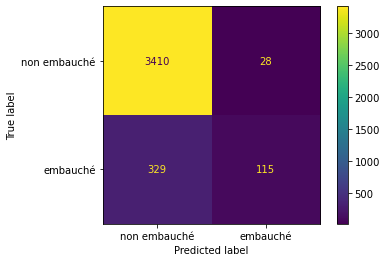

In [48]:
plot_confusion_matrix(model,
                     X_test,
                     y_test,
                     values_format='d',
                      display_labels=['non embauché','embauché'])

#### Optimisation des hyperparamètres

Quelques recommandation trouvés dans le manuel de XGBoost: 

" Traitement d'un ensemble de données déséquilibré

Pour des cas courants tels que le journal des clics publicitaires, l'ensemble de données est extrêmement déséquilibré. Cela peut affecter la formation du modèle XGBoost, et il y a deux façons de l'améliorer.
Si vous ne vous souciez que de la métrique de performance globale (AUC) de votre prédiction

        Équilibrez les poids positifs et négatifs via scale_pos_weight.
        Utilisez l'AUC pour l'évaluation "
C'est ce que nous allons faire.

In [49]:
# First round params

param_grid={
     "learning_rate"       : [ 0.0, 0.10, 0.15 ] , # pas de l'optimisateur
     "max_depth"           : [ 3, 4, 5],    # Profondeur maximale d'un arbre. 
                                            #L'augmentation de cette valeur rendra le modèle plus complexe
                                            #et plus susceptible à l'overfitting.
     "reg_lambda"          : [0, 1.0, 10.0], #  paramètre de régularisation
     "gamma"               : [ 0.0, 0.25, 1.0  ], # paramètre qui encourage le prunning
     "scale_pos_weight"    : [ 1, 3 ]   # tenir en compte que notre data set est déséquilibré
    }


model = XGBClassifier(Objective='binary:logistic', ## problème de classification binaire
                      seed=42,
                      subsample=0.9,   ## à chaque construction d'arbre un sous-ensemble aléatoire de 90% 
                                       ## sera choisi 
                      colsample_bytree=0.5 ## pour chaque arbre un choix aléatoire de 50% des colonnes sera réalisé
                                          ## Ces deux paramètres permettent d'éviter l'overfitting 
                                          ##et d'accélèrer la validation croisée
                     )
grid_search = GridSearchCV(model,
                           param_grid=param_grid,
                           scoring="roc_auc",   ## comme recommander par le manuel
                           verbose=0,
                           n_jobs=-1, ## utiliser tous les noyaux existants
                           cv=3)
grid_result = grid_search.fit(X_train, y_train)




[10:30:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { Objective } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:30:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [50]:
grid_result.best_params_

{'gamma': 1.0,
 'learning_rate': 0.15,
 'max_depth': 5,
 'reg_lambda': 10.0,
 'scale_pos_weight': 1}

* Nous allons maintenant modifier notre liste de valeurs de paramètres en fonction des résultats de la validation croisée. Pour chaque paramètre, si la valeur résultante est au milieu de la liste de ses choix de valeurs, nous la fixons à cette valeur, sinon nous repoussons ses choix de valeurs si la valeur résultante est au bord de la liste.

In [53]:
# Second Round
param_grid={
     "learning_rate"       : [0.15, 2.0, 3.0] , ## on le fixe à cette valeur puisque cette valeur
                                        
     "max_depth"           : [ 5,7,9],
     "reg_lambda"          : [10.0, 12.0, 15.0], ## on pousse à des valuers plus grandes
     "gamma"               : [ 1.0, 1.5, 2],
     "scale_pos_weight"    : [ 0.7, 1 ]
}

grid_search = GridSearchCV(model,
                           param_grid=param_grid,
                           scoring="roc_auc",
                           verbose=0,
                           n_jobs=-1,
                           cv=3)
grid_result = grid_search.fit(X_train, y_train)
grid_result.best_params_

[10:34:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { Objective } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:34:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'gamma': 2,
 'learning_rate': 0.15,
 'max_depth': 5,
 'reg_lambda': 10.0,
 'scale_pos_weight': 0.7}

In [54]:
# Third Round
param_grid={
     "learning_rate"       : [0.15] , ## on le fixe à cette valeur puisque cette valeur
                                        ##se situe au milieu de la liste précédante
     "max_depth"           : [ 5],
     "reg_lambda"          : [10.0], ## on pousse à des valuers plus grandes
     "gamma"               : [ 2, 5, 7],
     "scale_pos_weight"    : [ 0.7 ]
}

grid_search = GridSearchCV(model,
                           param_grid=param_grid,
                           scoring="roc_auc",
                           verbose=0,
                           n_jobs=-1,
                           cv=3)
grid_result = grid_search.fit(X_train, y_train)
grid_result.best_params_

[10:35:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { Objective } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:35:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'gamma': 2,
 'learning_rate': 0.15,
 'max_depth': 5,
 'reg_lambda': 10.0,
 'scale_pos_weight': 0.7}

[10:46:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { Objective } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Test performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      3438
           1       0.93      0.03      0.06       444

    accuracy                           0.89      3882
   macro avg       0.91      0.52      0.50      3882
weighted avg       0.89      0.89      0.84      3882



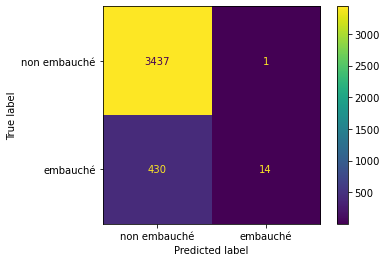

In [66]:
model = XGBClassifier(Objective='binary:logistic',
                      seed=42,
                      subsample=0.9,
                      colsample_bytree=0.5,
                      gamma= 0.2,
                     learning_rate= 0.15,
                     max_depth= 5,
                     reg_lambda=10.0,
                     scale_pos_weight= 0.7
                     )
model.fit(X_train,
          y_train,
          early_stopping_rounds=5,
          verbose=0,
          eval_metric='aucpr',
          eval_set=[(X_test,y_test)]
         )

plot_confusion_matrix(model,
                     X_test,
                     y_test,
                     values_format='d',
                      display_labels=['non embauché','embauché'])
y_test_hat = model.predict(X_test)

print('Test performance')
print('-------------------------------------------------------')
print(classification_report(y_test, y_test_hat))


In [67]:
y_test_hat = model.predict(X_test)

print('Test performance')
print('-------------------------------------------------------')
print(classification_report(y_test, y_test_hat))


Test performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      3438
           1       0.93      0.03      0.06       444

    accuracy                           0.89      3882
   macro avg       0.91      0.52      0.50      3882
weighted avg       0.89      0.89      0.84      3882



###  Les variables les plus importantes du modèle

[11:10:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { Objective } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:10:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


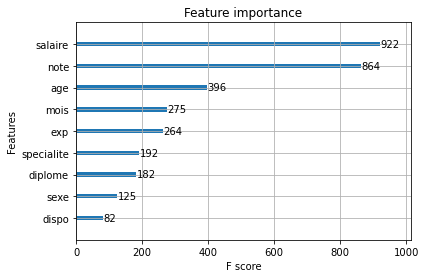

In [70]:
model.fit(X_train, y_train)
plot_importance(model)
plt.show()

* Comme il s'agit d'un poste de recherche, les critères les plus importants seront généralement : la note et l'âge et l'expérience. La note obtenu dans l'exercice de recherche d'or domine sur les autres variables ce qui est attendu. 
* L'expérience est importante mais vient après la note. 
* Le salaire qui est très important selon le graphique ci-dessus, ceci peut s'expliquer par la stratégie employée par le centre de recherche qui cherche à minimiser le coût autant que possible comme vu dans la section data engineering.
* Comme vu sur auparavant les diplomes licence et master sont les plus demandé et la spécialité la plus demandé est archeologie.
* Le sexe et la disponibilité ne sont pas des critères très importants, surtout pour les postes de recherche. Nous avon presque le même pourcentage d'admission pour ces variables. 
* La variable mois a un impact similaire aux sexe et disponibilité. Le modèle est plus performant en ajoutant cette variable.

### Deux à trois pistes d'amélioration du modèle

* Un modèle stacking améliorera les performances en votant pour les résultats de différents modèles. 
* La définition d'autres variables sera également bénéfique. En analysant en détail la variable date et en corrélant les variables existantes avec une compréhension approfondie du problème.
* Le sur-échantillonnage (oversampling) sur les candidats embauchés ou le sous-échantillonnage(undersampling) sur les candidats non embauchés peut également améliorer les performances.
* L'utilisation d'autres méthodes d'encodage (Effect Encoder, Hash Encoder, ...)
* Un traitement différent des valeurs manquantes (éviter de supprimer des lignes). XGBoost accepte les valeurs manquantes si elles sont remises à zéro.